In [1]:
import sys
import os
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf

import model_explain.plot as meplot
import model_explain.shap as meshap

import data_visualization.distribution_plot as dbplot

from numpy import array,asarray,zeros
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
import pycountry
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data'

In [8]:
country_vacc = pd.read_csv(os.path.join(root_path, "country_vaccinations.csv"))
country_vacc_manu = pd.read_csv(os.path.join(root_path, "country_vaccinations_by_manufacturer.csv"))
country_vacc['date']=pd.to_datetime(country_vacc['date'], errors='coerce').dt.date
country_vacc_manu['date']=pd.to_datetime(country_vacc_manu['date'], errors='coerce').dt.date

In [9]:
country_vacc.head(3)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/


In [10]:
country_vacc_manu.head(3)

,location,date,vaccine,total_vaccinations
0,Chile,2020-12-24,Pfizer/BioNTech,420
1,Chile,2020-12-25,Pfizer/BioNTech,5198
2,Chile,2020-12-26,Pfizer/BioNTech,8338


In [5]:
country_vacc_manu.location.unique()

array(['Chile', 'Czechia', 'France', 'Germany', 'Iceland', 'Italy',
       'Latvia', 'Lithuania', 'Romania', 'Switzerland', 'United States'],
      dtype=object)

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


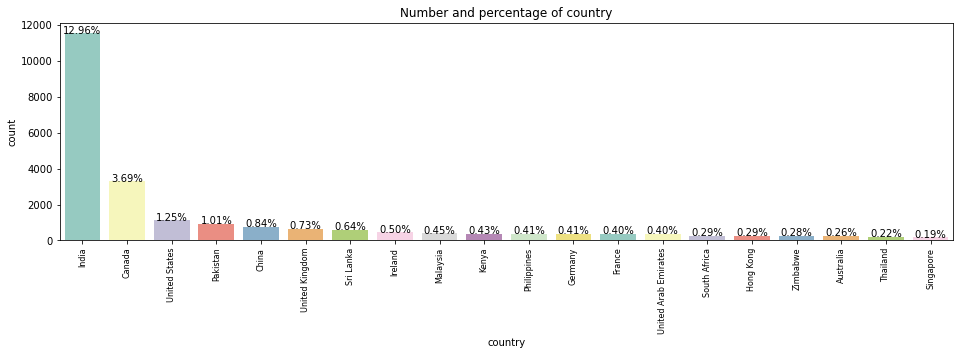

In [13]:
dbplot.plot_count_dist("country", "country", data, 4, True)

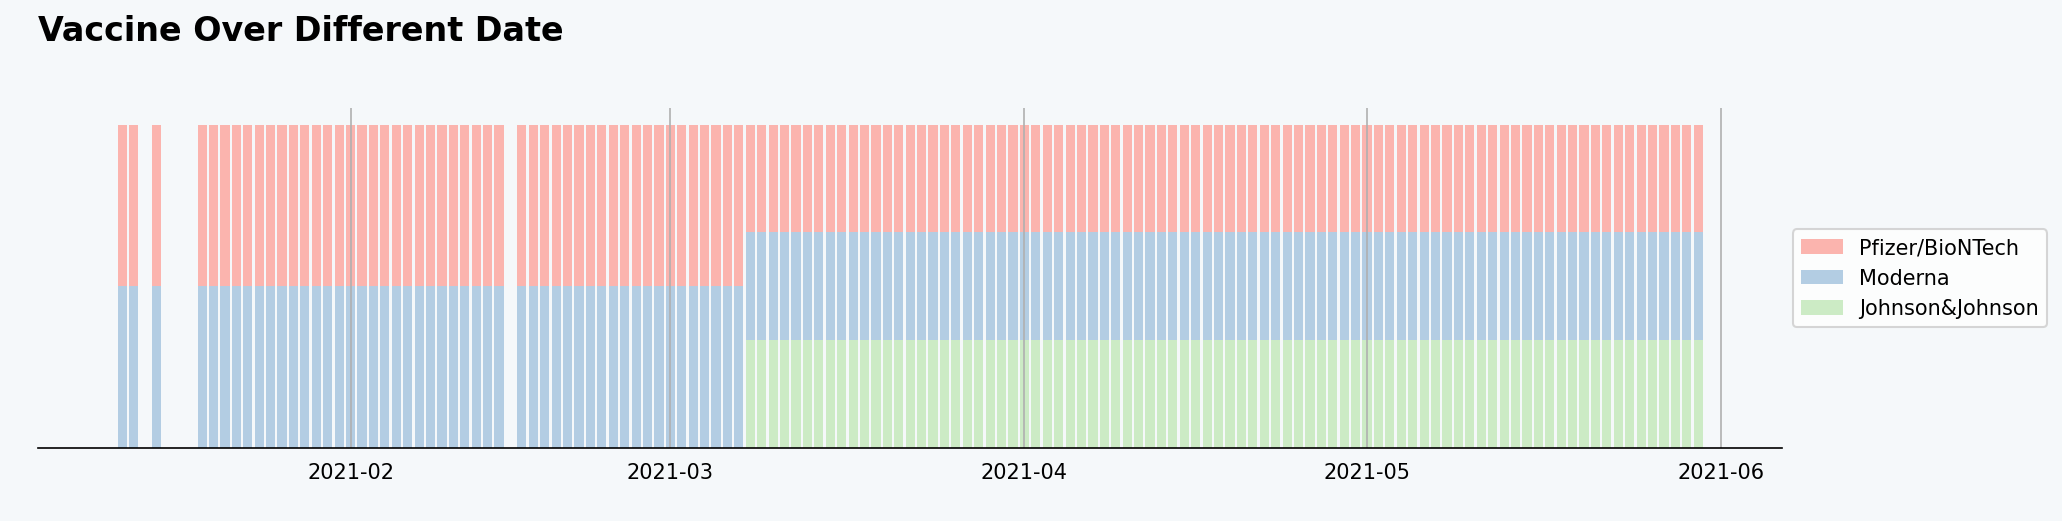

In [11]:
dbplot.generate_bar_proportion(country_vacc_manu[country_vacc_manu.location=='United States'], 'vaccine', 'date', color = 0, order = False, topn = 10)